In [1]:
import matplotlib
#matplotlib.use('Agg')

In [2]:
from scipy import signal
import os
import datetime
import time
import copy
import shutil
import sys
sys.path.append('/mnt/nfs/d50/pastel/USERS/lecestres/analyse/')

from function_read import *
#from data.set_output_name import *
#from forecast_veri import *
#from data.aux_and_plot import *
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import cm

from mpl_toolkits.basemap import Basemap, shiftgrid
from scipy.stats import gaussian_kde

import calendar
import locale
locale.setlocale( locale.LC_ALL , 'en_US' )
from netCDF4 import num2date, date2num

from joblib import Parallel, delayed
import joblib

from HWMI import *

In [3]:
### Local experience
#point in north atlantic
lat = 40
lon = -35

In [4]:
fileGrep = "/cnrm/pastel/USERS/lecestres/NO_SAVE/data/ocean_reanalysis_GREP/sst_GREP_1d_199301_201812.nc"
varf = netCDF4.Dataset(fileGrep)

In [5]:
local_sst = varf.variables['thetao_mean'][:,0,lat,lon]

In [6]:
### PERCENTILE THRESHOLD
percent_thresh = 95
#percent_thresh = 90

### MINIMAL DURATION OF A HW
duration_min = 5
#duration_min = 3
start_year = 1993
end_year=2016
nyear = end_year-start_year+1
nday_clim=120
nday=90
percent_thresh=95
global_sst = np.zeros((nyear,nday_clim))
sst = np.zeros((nyear, nday))
nday = 90
season_start_day = [11,1] #1stDec
season_end_day = [3,1] #1stMarch
first_day = 30

In [12]:
for i,iyear in enumerate(range(start_year, end_year+1)):
    i_start_day = (date(iyear,season_start_day[0], season_start_day[1])-date(start_year,1,1)).days
    i_end_day = (date(iyear+1,season_end_day[0], season_end_day[1])-date(start_year,1,1)).days
    global_sst[i,:]=local_sst[i_start_day:i_end_day][:nday_clim]
    sst[i,:]=local_sst[i_start_day+first_day:i_end_day][:nday]

In [13]:
global_percentile = np.zeros(nday_clim)
percentile = np.zeros(nday)
for iday in range(nday_clim):
    global_percentile[iday] = np.percentile(global_sst[:,iday], percent_thresh, axis=0)
for iday in range(nday):
    percentile[iday]=global_percentile[iday+first_day].copy()

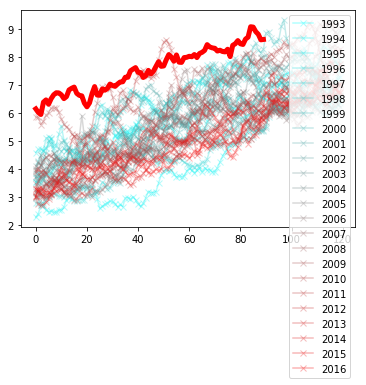

In [14]:
for i in range(nyear):
    plt.plot(global_sst[i,:],'bx-', alpha = 0.3, color=(i/nyear,1-i/nyear,1-i/nyear), label=i+start_year)
plt.plot(percentile,'r-', linewidth=5)
plt.legend()

In [15]:
global_perc_thresh_clim = np.polyval(np.polyfit(range(nday_clim), global_percentile[:], deg=6), range(nday_clim))
perc_thresh_clim = np.polyval(np.polyfit(range(nday), percentile[:], deg=6), range(nday))

In [38]:
yearplot = 2011-start_year
diff = sst[yearplot,:]-perc_thresh_clim
whereabovetresh_1=np.where(sst[yearplot,:]>perc_thresh_clim)[0]
whereHW_1 = whereabovetresh_1.copy()
wheresubHW_1 = []
Ms_1=[]
index=0
parcours = True
while parcours:
    val = whereHW_1[index]
    check = 1
    goout=False
    while not(goout):
        if whereHW_1[index+check] == val+check:
            check +=1
            if index+check>=len(whereHW_1):
                goout=True
        else:
            goout=True
    count_subHW=0
    index += check
    while check>=duration_min:
        subHW=val+count_subHW
        wheresubHW_1.append((subHW, duration_min))
        Ms_1.append(np.sum(diff[subHW:subHW+duration_min]))
        check-=duration_min
        if check<duration_min and check>0:
            wheresubHW_1.append((subHW+duration_min, check))
            Ms_1.append(np.sum(diff[subHW+duration_min:subHW+duration_min+check]))
        count_subHW+=duration_min
    if index>=len(whereHW_1):
        print(index)
        parcours=False

20


In [39]:
maxMspos_1, subHWlength_1 = wheresubHW_1[np.argmax(Ms_1)]

In [40]:
maxMspos_1 = int(maxMspos_1 + 0.5*(subHWlength_1-1))
maxMs_beg_1, maxMs_end_1 = int(maxMspos_1 - 0.5*(subHWlength_1-1)), int(maxMspos_1 + 0.5*(subHWlength_1-1))

Text(45,5.9,'MHW')

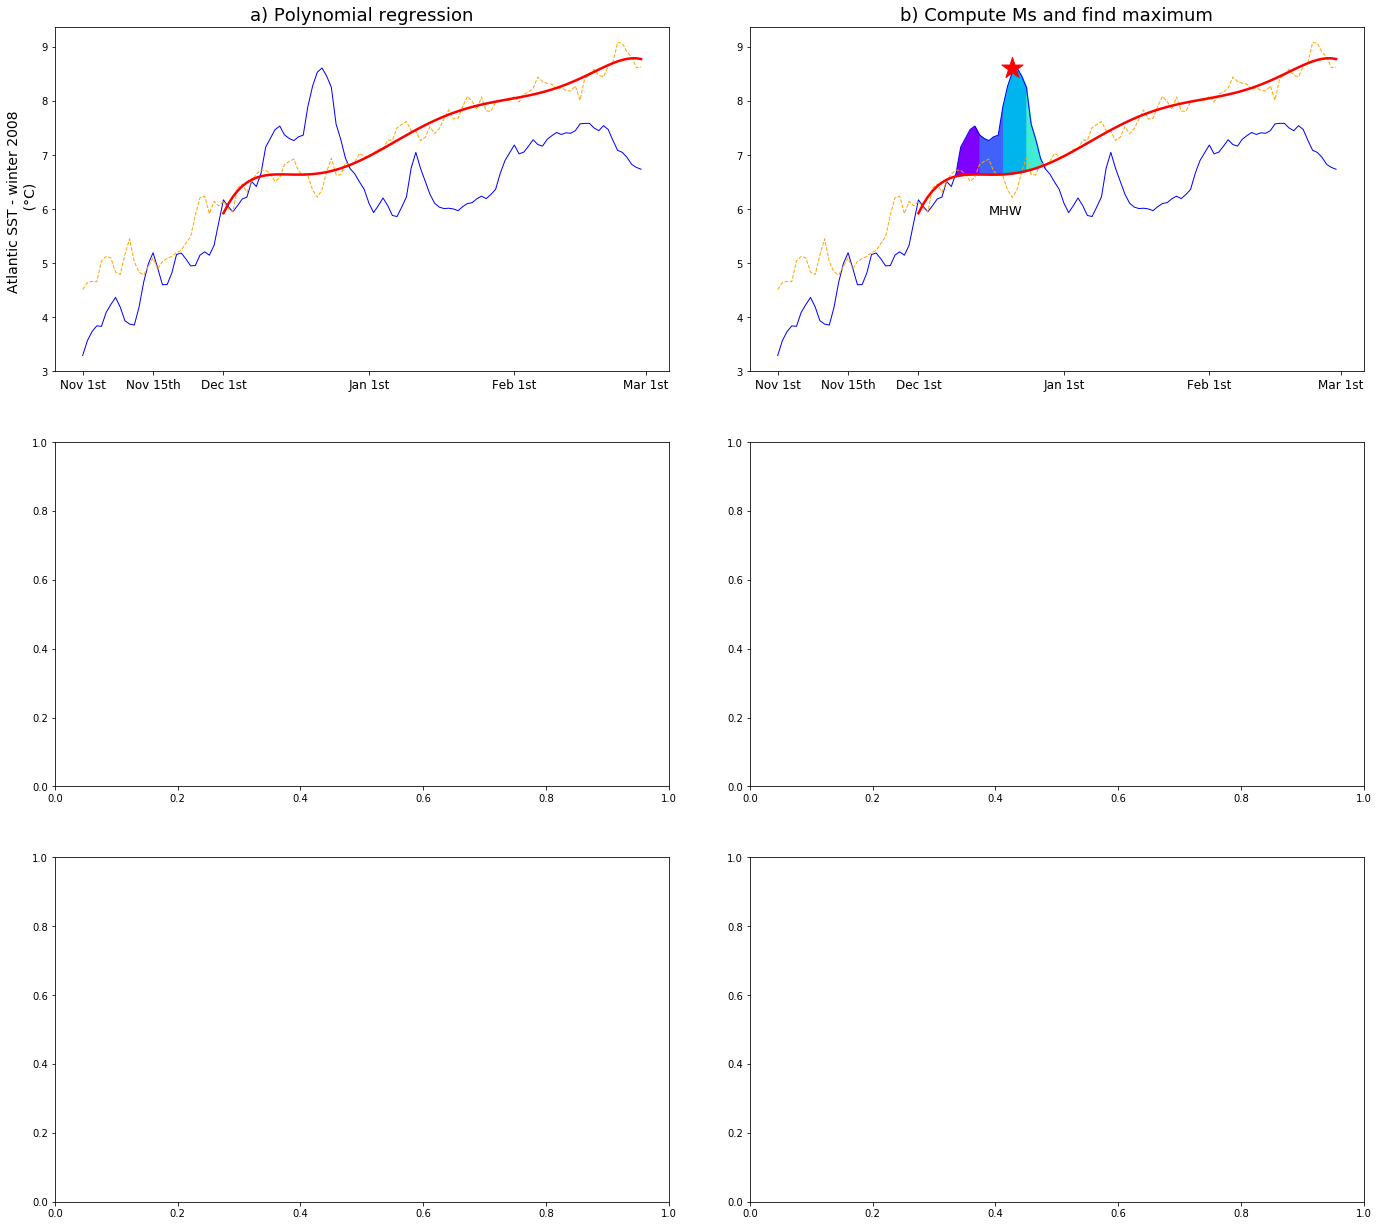

In [46]:
nline=3
ncol=2

fig, ax = plt.subplots(nline,ncol, figsize=(20,18))
fig.tight_layout(pad=5)
titlefonsize=18

yearplot = 2011-start_year
ax[0,0].set_xticks([0,15,30,61,92,120])
ax[0,0].set_xticklabels(["Nov 1st", "Nov 15th","Dec 1st", "Jan 1st", "Feb 1st", "Mar 1st"], fontsize=12)
ax[0,0].plot(global_sst[yearplot],'b-',linewidth=1)
ax[0,0].plot(global_percentile,'--', color='orange', linewidth=1, alpha=1)
ax[0,0].plot(range(first_day,nday+first_day),perc_thresh_clim[:], 'r-', linewidth=2.5)
ax[0,0].set_title("a) Polynomial regression", fontsize=titlefonsize)
ax[0,0].set_ylabel("Atlantic SST - winter 2008 \n (°C)", fontsize="14")

ax[0,1].set_title("b) Compute Ms and find maximum", fontsize=titlefonsize)
newcolors = cm.rainbow(np.linspace(0, 0.5, 5))

ax[0,1].set_xticks([0,15,30,61,92,120])
ax[0,1].set_xticklabels(["Nov 1st", "Nov 15th","Dec 1st", "Jan 1st", "Feb 1st", "Mar 1st"], fontsize=12)
ax[0,1].plot(global_sst[yearplot],'b-',linewidth=1)
ax[0,1].plot(global_percentile,'--', color='orange', linewidth=1, alpha=1)
ax[0,1].plot(range(first_day,nday+first_day),perc_thresh_clim[:], 'r-', linewidth=2.5)

for isubHW, (start,duration) in enumerate(wheresubHW_1):
    if isubHW==0:
        ax[0,1].fill_between(np.arange(start+first_day,start+first_day+duration+1), perc_thresh_clim[start:start+duration+1], sst[yearplot,start:start+duration+1], color=newcolors[isubHW], zorder=1)
    else:
        ax[0,1].fill_between(np.arange(start+first_day,start+first_day+duration+1), perc_thresh_clim[start:start+duration+1], sst[yearplot,start:start+duration+1], color=newcolors[isubHW], zorder=1)
#ax[0,1].fill_between(np.arange(maxMs_beg-2,maxMs_end), perc_thresh_clim[maxMs_beg-2:maxMs_end], sst[yearplot,maxMs_beg-2:maxMs_end], color="red", zorder=-1)
ax[0,1].scatter(first_day+maxMspos_1, sst[yearplot,maxMspos_1]+0.07,  color="r",  marker="*", s=500, zorder=5)
ax[0,1].text( 45, 5.9, "MHW", fontsize=13)

In [32]:
Ms_years = np.zeros(nyear)
for yearplot in range(nyear):
    diff = sst[yearplot,:]-perc_thresh_clim
    whereabovetresh=np.where(sst[yearplot,:]>perc_thresh_clim)[0]
    whereHW = whereabovetresh.copy()
    wheresubHW = []
    Ms=[0]
    index=0
    parcours = True
    print('yearplot : ', yearplot)
    print('whereHW : ', whereHW)
    if len(whereHW)>=duration_min:
        while parcours:
            val = whereHW[index]
            check = 1
            goout=False
            while not(goout):
                if whereHW[index+check] == val+check: #check temporal continuity
                    check +=1
                    if index+check>=len(whereHW):
                        goout=True
                else:
                    goout=True
            count_subHW=0
            index += check
            while check>=duration_min:
                subHW=val+count_subHW
                wheresubHW.append((subHW, duration_min))
                Ms.append(np.sum(diff[subHW:subHW+duration_min]))
                check-=duration_min
                if check<duration_min and check>0:
                    wheresubHW.append((subHW+duration_min, check))
                    Ms.append(np.sum(diff[subHW+duration_min:subHW+duration_min+check]))
                count_subHW+=duration_min
            if index>=len(whereHW)-1:
                parcours=False
    print('MaxMs : ', np.max(Ms))    
        #maxMspos, subHWlength = wheresubHW[np.argmax(Ms)]
    Ms_years[yearplot]=np.max(Ms)

yearplot :  0
whereHW :  []
MaxMs :  0
yearplot :  1
whereHW :  []
MaxMs :  0
yearplot :  2
whereHW :  [39 40 45 46 53]
MaxMs :  0
yearplot :  3
whereHW :  [ 0  7  8  9 10 28 29 30 31 32 33 35 36 37 38 39]
MaxMs :  1.003367634530549
yearplot :  4
whereHW :  []
MaxMs :  0
yearplot :  5
whereHW :  []
MaxMs :  0
yearplot :  6
whereHW :  [35 38 39 40 41 48 51 52 53 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70]
MaxMs :  3.4480369176443837
yearplot :  7
whereHW :  []
MaxMs :  0
yearplot :  8
whereHW :  [ 0  3  4  7  8  9 13 14 15 16 17 18 43 59 60]
MaxMs :  1.148628343305977
yearplot :  9
whereHW :  []
MaxMs :  0
yearplot :  10
whereHW :  [41]
MaxMs :  0
yearplot :  11
whereHW :  [83 84 85 86 87 88 89]
MaxMs :  1.2802867607047652
yearplot :  12
whereHW :  []
MaxMs :  0
yearplot :  13
whereHW :  [26 27 28 29]
MaxMs :  0
yearplot :  14
whereHW :  [82 83]
MaxMs :  0
yearplot :  15
whereHW :  [22 23 26 27 29 31 32 33 34 35 36 37 38 47 48 49 55 77 78 79 80 81 82 83
 84 85 86 87]
MaxMs :  2.24

In [33]:
ecdfmaxfit = Ms_years[Ms_years>0]
kde = gaussian_kde(ecdfmaxfit)
x = np.linspace(0,1,200)*np.max(Ms_years[Ms_years>0])
y = [kde.integrate_box_1d(0,ix) for ix in x]

Text(0.5,1,'d) Estimate SMs')

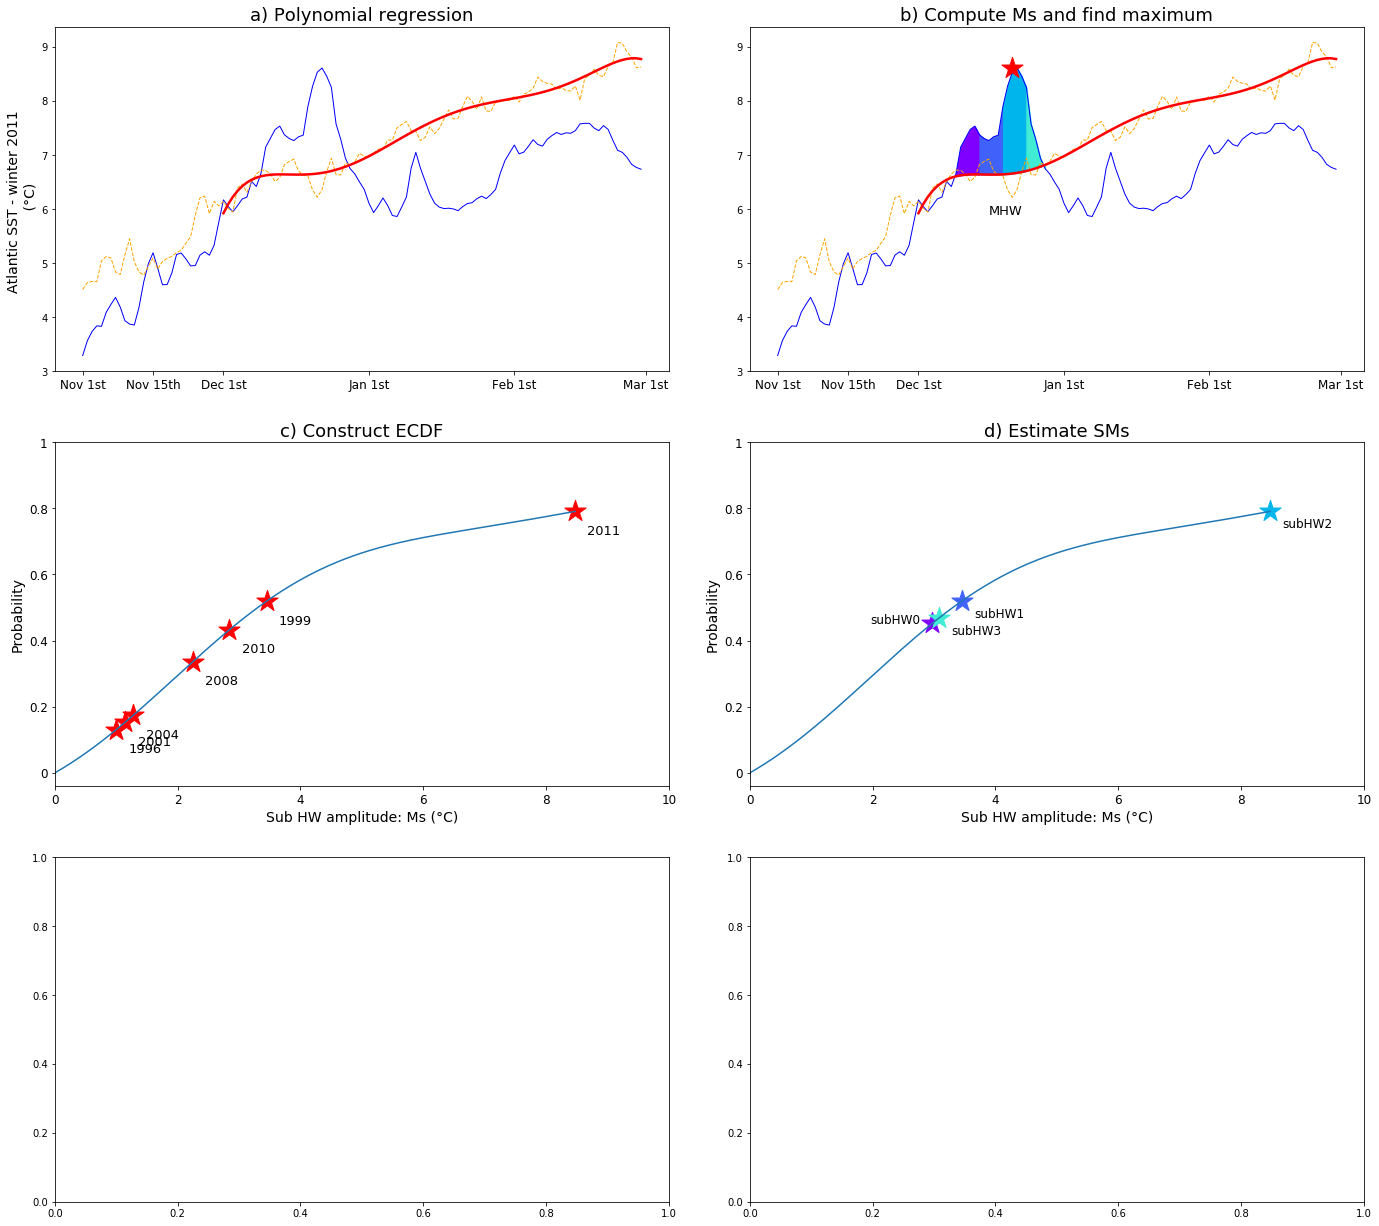

In [68]:
nline=3
ncol=2

fig, ax = plt.subplots(nline,ncol, figsize=(20,18))
fig.tight_layout(pad=5)
titlefonsize=18

yearplot = 2011-start_year
ax[0,0].set_xticks([0,15,30,61,92,120])
ax[0,0].set_xticklabels(["Nov 1st", "Nov 15th","Dec 1st", "Jan 1st", "Feb 1st", "Mar 1st"], fontsize=12)
ax[0,0].plot(global_sst[yearplot],'b-',linewidth=1)
ax[0,0].plot(global_percentile,'--', color='orange', linewidth=1, alpha=1)
ax[0,0].plot(range(first_day,nday+first_day),perc_thresh_clim[:], 'r-', linewidth=2.5)
ax[0,0].set_title("a) Polynomial regression", fontsize=titlefonsize)
ax[0,0].set_ylabel("Atlantic SST - winter "+str(yearplot+start_year)+" \n (°C)", fontsize="14")

ax[0,1].set_title("b) Compute Ms and find maximum", fontsize=titlefonsize)
newcolors = cm.rainbow(np.linspace(0, 0.5, 5))

ax[0,1].set_xticks([0,15,30,61,92,120])
ax[0,1].set_xticklabels(["Nov 1st", "Nov 15th","Dec 1st", "Jan 1st", "Feb 1st", "Mar 1st"], fontsize=12)
ax[0,1].plot(global_sst[yearplot],'b-',linewidth=1)
ax[0,1].plot(global_percentile,'--', color='orange', linewidth=1, alpha=1)
ax[0,1].plot(range(first_day,nday+first_day),perc_thresh_clim[:], 'r-', linewidth=2.5)

for isubHW, (start,duration) in enumerate(wheresubHW_1):
    if isubHW==0:
        ax[0,1].fill_between(np.arange(start+first_day,start+first_day+duration+1), perc_thresh_clim[start:start+duration+1], sst[yearplot,start:start+duration+1], color=newcolors[isubHW], zorder=1)
    else:
        ax[0,1].fill_between(np.arange(start+first_day,start+first_day+duration+1), perc_thresh_clim[start:start+duration+1], sst[yearplot,start:start+duration+1], color=newcolors[isubHW], zorder=1)
#ax[0,1].fill_between(np.arange(maxMs_beg-2,maxMs_end), perc_thresh_clim[maxMs_beg-2:maxMs_end], sst[yearplot,maxMs_beg-2:maxMs_end], color="red", zorder=-1)
ax[0,1].scatter(first_day+maxMspos_1, sst[yearplot,maxMspos_1]+0.07,  color="r",  marker="*", s=500, zorder=5)
ax[0,1].text( 45, 5.9, "MHW", fontsize=13)


ax[1,0].plot(x,y)
for iyear in range(nyear):
    M_i = Ms_years[iyear]
    if M_i!=0:
        ax[1,0].scatter(M_i, kde.integrate_box_1d(0,M_i),  color="r",  marker="*", s=500, zorder=2)
        ax[1,0].text(M_i+0.2, kde.integrate_box_1d(0,M_i)-0.07, str(iyear+start_year), fontsize=13)

ax[1,0].set_ylabel("Probability", fontsize="14")
ax[1,0].set_xlabel("Sub HW amplitude: Ms (°C)", fontsize="14")
ax[1,0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1,0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)
ax[1,0].set_xlim(0,10)
ax[1,0].set_xticks([0,2,4,6,8,10])
ax[1,0].set_xticklabels([0,2,4,6,8,10], fontsize=12)
ax[1,0].set_title("c) Construct ECDF", fontsize=titlefonsize)


ax[1,1].plot(x,y)
for isubHW, (start,duration) in enumerate(wheresubHW_1):
    place_legend = (isubHW/length)*0.1
    M_i = Ms_1[isubHW]
    ax[1,1].scatter(M_i, kde.integrate_box_1d(0,M_i), color=newcolors[isubHW], marker="*", s=500, zorder=2)
    if isubHW == 0:
        ax[1,1].text(M_i-1,kde.integrate_box_1d(0,M_i), 'subHW'+str(isubHW), fontsize=12)
    elif isubHW == 3:
        ax[1,1].text(M_i+0.2,kde.integrate_box_1d(0,M_i)-0.05, 'subHW'+str(isubHW), fontsize=12)
    else:
        ax[1,1].text(M_i+0.2,kde.integrate_box_1d(0,M_i)-0.05, 'subHW'+str(isubHW), fontsize=12)

ax[1,1].set_ylabel("Probability", fontsize="14")
ax[1,1].set_xlabel("Sub HW amplitude: Ms (°C)", fontsize="14")
ax[1,1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1,1].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)
ax[1,1].set_xlim(0,10)
ax[1,1].set_xticks([0,2,4,6,8,10])
ax[1,1].set_xticklabels([0,2,4,6,8,10], fontsize=12)
ax[1,1].set_title("d) Estimate SMs", fontsize=titlefonsize)


In [ ]:
for j,jmemb in enumerate(range(first_memb, last_memb)):
        for i,iyear in enumerate(range(start_year, end_year+1)):
            #print(i, iyear)
            i_start_day = (date(iyear,season_start_day[0], season_start_day[1])-date(start_year,1,1)).days
            i_end_day = (date(iyear+1,season_end_day[0], season_end_day[1])-date(start_year,1,1)).days
            
            if cross_greenwich:
                #print(x0,x1)
                target_W=varf.variables[varname][i_start_day:i_end_day,jmemb,:,x0:360][:nday,:,:]
                target_E=varf.variables[varname][i_start_day:i_end_day,jmemb,:,0:x1][:nday,:,:]
                #print(target_W.shape, target_E.shape)
                target_lon=np.flip(np.ma.concatenate((target_W,target_E), axis=2), axis=1)
            else:
                target_lon=np.flip(varf.variables[varname][i_start_day:i_end_day,jmemb,:,x0:x1][:nday,:,:],axis=1)
            target[i,:,j,:,:]=target_lon[:,y_up:y_down,:]
            print((j*nyear+i+1)/(nyear*nmemb)*100, ' % done after : ', time.time()-time_start)

In [ ]:
### Local experience
#point in north atlantic
lat = 40
lon = -35

### EXPERIENCE NAME
expname = "ocean_reanalysis_GREP"
#expname = "sst_retroprevision_sys7"

### PERCENTILE THRESHOLD
percent_thresh = 95
#percent_thresh = 90

### MINIMAL DURATION OF A HW
duration_min = 5
#duration_min = 3

### REGION OF EXPERIENCE

#reg_name = 'north_pacific'
#reg_name = 'north_atlantic'
#reg_name = 'indian_ocean'
#reg_name = 'austral_ocean'
#reg_name = 'tropical_atlantic'
#reg_name = 'tropical_pacific'
reg_name = 'mediterranee'
#reg_name = 'global'

if reg_name == 'north_pacific':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([120, -120])
    central_lon = 180
    cross_greenwich = False
    cross_antimeridian = True
if reg_name == 'north_atlantic':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([-80, 0])
    central_lon = 320
    cross_greenwich = False
    cross_antimeridian = False
if reg_name == 'indian_ocean':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([45, 110])
    central_lon = 77.5
    cross_greenwich = False
    cross_antimeridian = False
if reg_name == 'austral_ocean':
    lats_bnds = np.array([-90,-30])
    lons_bnds = np.array([-180, 180])
    central_lon = 0
    cross_greenwich = True
    cross_antimeridian = False
if reg_name == 'tropical_atlantic':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([-70, 20])
    central_lon = 335
    cross_greenwich = True
    cross_antimeridian = False
if reg_name == 'tropical_pacific':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([120, -70])
    central_lon = -155
    cross_greenwich = False
    cross_antimeridian = True
if reg_name == 'mediterranee':
    lats_bnds = np.array([30,50])
    lons_bnds = np.array([-5, 40])
    central_lon = 17.5
    cross_greenwich = True
    cross_antimeridian = False
if reg_name == 'global':
    lats_bnds = np.array([-90,90])
    lons_bnds = np.array([-180,180])
    cross_greenwich = True
    cross_antimeridian = False
nlat = lats_bnds[1]-lats_bnds[0]
if lons_bnds[1]<lons_bnds[0]:
    nlon = lons_bnds[1]%360-lons_bnds[0]
else:
    nlon = lons_bnds[1]-lons_bnds[0]
#print('nlon : ', nlon)

### YEARS
if expname == 'ocean_reanalysis_GREP':
    end_year=2016
    start_year=1993
elif expname == 'sst_retroprevision_sys7':
    end_year=2016
    start_year=1993
nyear=end_year-start_year+1

### SEASON
#season = "NDJFMAM"
season = "DJF"
if season == 'NDJFMAM':
    nday = 211
    season_start_day = [11,1] #1stNov
    season_end_day = [5,31] #31stMay
    first_day = 0
    
elif season == 'DJF':
    nday = 90
    season_start_day = [12,1] #1stDec
    season_end_day = [3,1] #1stMarch
    first_day = 30
    
ndayseas = nday//duration_min +1

if expname == "ocean_reanalysis_GREP":
    ### NAME OF VARIABLE IN THE NC FILE
    varname = 'thetao_mean'
    
    ### NUMBER OF MEMBS
    first_memb = 0
    last_memb = 1
    nmemb = last_memb-first_memb
    
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str = "CV"
    else:
        cv_str = 'notCV'
        
elif expname == "sst_retroprevision_sys7":
    ### NAME OF VARIABLE IN THE NC FILE
    varname = 'sst'
    
    ### NUMBER OF MEMBS
    first_memb = 19
    last_memb = 25
    nmemb = last_memb-first_memb
    
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str = "CV"
    else:
        cv_str = 'notCV'

### PARAMETERS
# Will be initialized later in the export
# parameters_str = reg_name + "_" + season + "_" + cv_str + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "ref%i-%i"%(start_year, end_year)

In [ ]:
time_start = time.time()

if expname == "ocean_reanalysis_GREP":
    fileGrep = "/cnrm/pastel/USERS/lecestres/NO_SAVE/data/ocean_reanalysis_GREP/sst_GREP_1d_199301_201812.nc"
    varf = netCDF4.Dataset(fileGrep)
    x0,x1 = lons_bnds[0], lons_bnds[1]
    cross_greenwich = (x0<0 and x1>0)
    if x0<0:
        x0=x0+360
    if x1<=0:
        x1=x1+360
    y0,y1 = lats_bnds[0], lats_bnds[1]
    y_down,y_up = 90-y0, 90-y1
    lats_reg = varf.variables['lat'][y0+90:y1+90]
    if cross_greenwich:
        lons_reg_W = varf.variables['lon'][x0:360]
        lons_reg_E = varf.variables['lon'][0:x1]
        lons_reg=np.ma.concatenate((lons_reg_W, lons_reg_E))
    else:
        lons_reg = varf.variables['lon'][x0:x1]
        
    target=np.ma.zeros((nyear, nday, nmemb, nlat, nlon))
    for j,jmemb in enumerate(range(first_memb, last_memb)):
        for i,iyear in enumerate(range(start_year, end_year+1)):
            #print(i, iyear)
            i_start_day = (date(iyear,season_start_day[0], season_start_day[1])-date(start_year,1,1)).days
            i_end_day = (date(iyear+1,season_end_day[0], season_end_day[1])-date(start_year,1,1)).days
            
            if cross_greenwich:
                #print(x0,x1)
                target_W=varf.variables[varname][i_start_day:i_end_day,jmemb,:,x0:360][:nday,:,:]
                target_E=varf.variables[varname][i_start_day:i_end_day,jmemb,:,0:x1][:nday,:,:]
                #print(target_W.shape, target_E.shape)
                target_lon=np.flip(np.ma.concatenate((target_W,target_E), axis=2), axis=1)
            else:
                target_lon=np.flip(varf.variables[varname][i_start_day:i_end_day,jmemb,:,x0:x1][:nday,:,:],axis=1)
            target[i,:,j,:,:]=target_lon[:,y_up:y_down,:]
            print((j*nyear+i+1)/(nyear*nmemb)*100, ' % done after : ', time.time()-time_start)
             
elif expname == "sst_retroprevision_sys7":
    pathPrevi = "/cnrm/pastel/DATA/sys7/series/sst/HK/"
    files = glob(pathPrevi+"*.nc")
    files.sort()
    target = np.ma.zeros((nyear, nday, nmemb, nlat, nlon))
    for i,iyear in enumerate(range(start_year, end_year+1)):
        varf = netCDF4.Dataset(files[i])
        vararray, lats_reg, lons_reg = extract_array(varf, varname, nday,  np.array(lons_bnds), np.array(lats_bnds), start_time = first_day)
        varf.close()
        for j,jmemb in enumerate(range(first_memb, last_memb)):
            target[i,:,j,:,:] = vararray[:,jmemb,:,:]    
            target.mask[i,:,j,:,:] = vararray.mask[:,jmemb,:,:]
            print((i*nmemb+j+1)/(nyear*nmemb)*100, ' % done after : ', time.time()-time_start)

In [ ]:
target.shape

In [ ]:
plt.imshow(target[8,27,0,:,:])

In [ ]:
def plotfield(ax, lon, lat, field, title): #, title, bounds, cmin, cmax, cmap, norm, cbar=True, signi=False, signicor=False, extend="neither"):
    #ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    if cross_greenwich:
        lon[lon>=180]=lon[lon>=180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    lon2d, lat2d = np.meshgrid(lon, lat)
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    
    ax.coastlines()
    plot = ax.contourf(lon2d, lat2d, field, bounds, transform=ccrs.PlateCarree(), cmap = cmap, norm=norm)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS)
    #fig.colorbar(plot, orientation = 'horizontal', ax=ax, shrink=0.4, spacing='proportional')
    #ax.set_title(title)

In [ ]:
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
cmap = mpl.cm.coolwarm
bounds = np.linspace(0,35,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
gridict = {'wspace' : 0.2, 'hspace' : 0.2}
ncol=1
nline=1
fig, axs = plt.subplots(ncols=ncol, nrows=nline, gridspec_kw=gridict, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=central_lon)})#, figsize=(10,3))
#fig.suptitle('HWMI, N95 and SSTmean spatial correlations in '+reg_name, fontsize = 20, family='sans-serif',fontweight='demibold')
plotfield(axs, lons_reg, lats_reg, np.flip(target[15,27,0,:,:],0), 'SST field in North Pacific')
export_path='SSTexample_'+reg_name
plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')